In [2]:
#Only for workstation, do not run this in local
import sys
import os

In [19]:
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
import astropy.constants as const
import jax.numpy as jnp
import numpy as np

In [20]:
from helens import LensEquationSolver
from herculens.Util import param_util
import functools
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
import jax
jax.config.update("jax_enable_x64", True)

In [162]:
import dynesty
from dynesty import plotting as dyplot
import corner 

In [21]:
def get_time_delay_distance(z_lens, z_source, cosmo = cosmo):
    ''' Returns the time delay distance in Mpc between a lens at redshift z_lens and a source at redshift z_source '''
    Dds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)
    Ds = cosmo.angular_diameter_distance(z_source)
    Dd = cosmo.angular_diameter_distance(z_lens)
    D_dt = (1+z_lens)*Ds*Dd/Dds
    return D_dt # In units of Mpc

In [22]:
arcsecond_to_radians = (1*u.arcsecond).to(u.radian).value #4.84814e-6 

In [25]:
#Setup the lens
zs_true = 2.0; zl_true = 0.5
phi_true = 8.0 # position angle, here in degree
q_true = 1#0.75 # axis ratio, b/a
e1_true, e2_true = param_util.phi_q2_ellipticity(phi_true * jnp.pi / 180, q_true) # conversion to ellipticities
print(e1_true, e2_true)
theta_E_true = 1.0 # Einstein radius
y0true = 0.8
y1true = 0.00
# y_true = jnp.array([y0true, y1true])
cx0_true, cy0_true = 0.0, 0.0 # position of the lens

lens_mass_model  = MassModel(["SIE"])
kwargs_lens_true = [
    {'theta_E': theta_E_true, 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true}  # SIE
]

0.0 0.0


In [43]:
#Set solver grid
npix = 100  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2.
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2.  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
base_pixel_grid = PixelGrid(
    nx=npix, ny=npix,
    ra_at_xy_0=ra_at_xy_0, dec_at_xy_0=dec_at_xy_0,
    transform_pix2angle=transform_pix2angle,
)
# Optionally create a higher-resolution grid for the solver
solver_pixel_grid = base_pixel_grid.create_model_grid(pixel_scale_factor=0.5)

# Retrieve the pixel coordinates as 2D arrays
solver_grid_x, solver_grid_y = solver_pixel_grid.pixel_coordinates
print(solver_grid_x.shape)

(200, 200)


In [44]:
solver_grid_x, solver_grid_y

(array([[-3.98, -3.94, -3.9 , ...,  3.9 ,  3.94,  3.98],
        [-3.98, -3.94, -3.9 , ...,  3.9 ,  3.94,  3.98],
        [-3.98, -3.94, -3.9 , ...,  3.9 ,  3.94,  3.98],
        ...,
        [-3.98, -3.94, -3.9 , ...,  3.9 ,  3.94,  3.98],
        [-3.98, -3.94, -3.9 , ...,  3.9 ,  3.94,  3.98],
        [-3.98, -3.94, -3.9 , ...,  3.9 ,  3.94,  3.98]], shape=(200, 200)),
 array([[-3.98, -3.98, -3.98, ..., -3.98, -3.98, -3.98],
        [-3.94, -3.94, -3.94, ..., -3.94, -3.94, -3.94],
        [-3.9 , -3.9 , -3.9 , ..., -3.9 , -3.9 , -3.9 ],
        ...,
        [ 3.9 ,  3.9 ,  3.9 , ...,  3.9 ,  3.9 ,  3.9 ],
        [ 3.94,  3.94,  3.94, ...,  3.94,  3.94,  3.94],
        [ 3.98,  3.98,  3.98, ...,  3.98,  3.98,  3.98]], shape=(200, 200)))

In [45]:
def ray_shooting_func(theta_x, theta_y, kwargs_lens):
    """Function that computes evaluates the lens equation to return beta = theta - alpha(theta)"""
    beta_x, beta_y = lens_mass_model.ray_shooting(theta_x, theta_y, kwargs_lens)
    return beta_x, beta_y

print(ray_shooting_func(-1.5, 0.0, kwargs_lens_true))

(Array(-0.5, dtype=float64), Array(0., dtype=float64))


In [46]:
#Set the solver function
solver = LensEquationSolver(solver_grid_x, solver_grid_y, ray_shooting_func)

In [80]:
# Hyperparameters of the solver
solver_params = {
    # You have to specify the number of predicted images in advance
    'nsolutions': 3,

    # Hyperparameters (see docstring above)
    'niter': 2, 
    'scale_factor': 2, 
    'nsubdivisions': 3,
}

# T0 KNOW MORE ABOUT THESE PARAMS USE THIS
#?LensEquationSolver.solve

In [81]:
#Based on your the grid resolution, 
#you can obtain a rough estimate of the solver accuracy of the predicted positions in image plane.

estim_acc = solver.estimate_accuracy(
    solver_params['niter'], 
    solver_params['scale_factor'], 
    solver_params['nsubdivisions']
)
print(f"Estimated accuracy in image plane (arcsec): {estim_acc:.2e}")

Estimated accuracy in image plane (arcsec): 1.25e-03


In [82]:
# Set the source position
some_beta_x, some_beta_y = -0.12, 0.15
some_beta = jnp.array([some_beta_x, some_beta_y])  # jnp.array is not absolutely necessary in this notebook

In [83]:
%%time
_ = solver.solve(
    some_beta, kwargs_lens_true, 
    **solver_params
)  # takes some time to JIT-compile

CPU times: user 5.5 s, sys: 1.48 s, total: 6.99 s
Wall time: 9.13 s


In [84]:
some_beta_x_, some_beta_y_ = 0.2, -0.3
some_beta_ = jnp.array([some_beta_x_, some_beta_y_])

In [85]:
%%time
result_thetas, result_betas = solver.solve(
    some_beta_, kwargs_lens_true,
    **solver_params
)  # this is now very fast and differentiable!

CPU times: user 152 ms, sys: 38.3 ms, total: 190 ms
Wall time: 152 ms


In [86]:
print(result_thetas)

[[ 3.92135624e-04 -7.84271247e-04]
 [-3.54987734e-01  5.32083333e-01]
 [ 7.54987734e-01 -1.13208333e+00]]


In [87]:
theta_ = np.arctan(some_beta_y_/some_beta_x_)
snorm_ = np.sqrt(some_beta_x_**2  + some_beta_y_**2)
im1_analyt_ = (snorm_+1)*np.array([np.cos(theta_),np.sin(theta_)])
im2_analyt_ = (snorm_-1)*np.array([np.cos(theta_),np.sin(theta_)])
print(im1_analyt_,im2_analyt_)
x0_ = np.array([im1_analyt_[0],im2_analyt_[0]])
x1_ = np.array([im1_analyt_[1],im2_analyt_[1]])
print(x0_)
print(x1_)

[ 0.7547002  -1.13205029] [-0.3547002   0.53205029]
[ 0.7547002 -0.3547002]
[-1.13205029  0.53205029]


In [88]:
lens_mass_model.ray_shooting(x0_,x1_,kwargs_lens_true)

(Array([0.2, 0.2], dtype=float64),
 Array([-0.29999999, -0.30000001], dtype=float64))

In [132]:
#True image positions
theta_tr = np.arctan(y1true/y0true)
snorm_tr = np.sqrt(y0true**2  + y1true**2)
im1_analyt = (snorm_tr+1)*np.array([np.cos(theta_tr),np.sin(theta_tr)])
im2_analyt = (snorm_tr-1)*np.array([np.cos(theta_tr),np.sin(theta_tr)])
x0_true = np.array([im1_analyt[0],im2_analyt[0]])
x1_true = np.array([im1_analyt[1],im2_analyt[1]])

print(x0_true)
print(x1_true)

x_true = np.array([np.array([x0_true[i],x1_true[i]]) for i in range(len(x0_true))])
print(x_true)

[ 1.8 -0.2]
[ 0. -0.]
[[ 1.8  0. ]
 [-0.2 -0. ]]


In [123]:
#For testing
theta_E_true2 = 3
kwargs_lens_true2 = [
    {'theta_E': theta_E_true2, 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true}  # SIE
]

theta_tr2 = np.arctan(y1true/y0true)
snorm_tr2 = np.sqrt(y0true**2  + y1true**2)*theta_E_true2
im1_analyt2 = (snorm_tr2+theta_E_true2)*np.array([np.cos(theta_tr),np.sin(theta_tr)])
im2_analyt2 = (snorm_tr2-theta_E_true2)*np.array([np.cos(theta_tr),np.sin(theta_tr)])
x0_true2 = np.array([im1_analyt2[0],im2_analyt2[0]])
x1_true2 = np.array([im1_analyt2[1],im2_analyt2[1]])

print(x0_true2)
print(x1_true2)

[ 5.4 -0.6]
[ 0. -0.]


In [148]:
# solve for image positions provided a lens model and the source position #
y0_test, y1_test = lens_mass_model.ray_shooting(x0_true,x1_true,kwargs_lens_true)
print('Ray traces source Pos:', y0_test, y1_test) # So the analytical result is are correct
print('Actual source Pos:', [y0true,y1true])
print('_'*50)
imnorm_true = jnp.sqrt(x0_true**2 + x1_true**2)
fermat_potential_true =  ((1/2) - imnorm_true)# This is in arcsec^2 dimensionfull, to get it as dimensionless divide it by einstein radius (in arcsec)**2 
print('Fermat Potential (analytical):', fermat_potential_true)

#Similar picture with einstein radius scaling
#So to get dimensionless potential divide by einstein_rad^2
fermat_potential_true_ = lens_mass_model.fermat_potential(x0_true2,x1_true2,kwargs_lens_true2)/theta_E_true2**2
print('Fermat Potential (Herculens):', fermat_potential_true)
print('_'*50)

time_delay_distance_true = get_time_delay_distance(zl_true, zs_true,cosmo=cosmo) #with Mpc unit
print('Time delay distance (D_dt) (in Mpc) [(1+zl)Ds*Dd/Dds]:', time_delay_distance_true)
Tstar_true = (time_delay_distance_true.to(u.m)/const.c)  * (theta_E_true * arcsecond_to_radians)**2
print('Tstar_true (D_dt*theta_E^2/c):', Tstar_true)

arrival_times_true = Tstar_true*fermat_potential_true
print('Arrival times:', arrival_times_true)
print('_'*50)

magnifications_true = imnorm_true/(imnorm_true - 1)
magnifications_true_ = lens_mass_model.magnification(x0_true,x1_true,kwargs_lens_true)
print('Magnification (Analytical)', magnifications_true)
print('Magnification (Herculens)', magnifications_true_)

print('_'*50)
print('Sort images according to their arrival times')

idx_sort = jnp.argsort(arrival_times_true)
x_true = x_true[idx_sort]; 
fermat_potential_true = fermat_potential_true[idx_sort]; 
magnifications_true = magnifications_true[idx_sort]; 
arrival_times_true = arrival_times_true[idx_sort]; 
print('Sorted Arrival Times:', arrival_times_true)
time_delays_true = np.diff(arrival_times_true) # Set time delays
print('Time delay (difference bet arrival time in order):', time_delays_true)
time_delays_true_ = Tstar_true*2*snorm_tr
print('Time delay (Analytical):', time_delays_true_)
print('_'*50)
# Set the luminosity distance
dL_true = cosmo.luminosity_distance(zs_true)
print('True luminosity distance (in Mpc):', dL_true)
print('*'*80)
print('Finally all the observables::')
dL_effectives_true = dL_true/jnp.sqrt(jnp.abs(magnifications_true))
print('Time delays (in days):', time_delays_true.to(u.day))
print('Effective dL:', dL_effectives_true)
print('*'*80)

Ray traces source Pos: [0.8 0.8] [ 0. -0.]
Actual source Pos: [0.8, 0.0]
__________________________________________________
Fermat Potential (analytical): [-1.3  0.3]
Fermat Potential (Herculens): [-1.3  0.3]
__________________________________________________
Time delay distance (D_dt) (in Mpc) [(1+zl)Ds*Dd/Dds]: 3073.3632080390958 Mpc
Tstar_true (D_dt*theta_E^2/c): 7435213.8456442775 s
Arrival times: [-9665777.99933756  2230564.15369328] s
__________________________________________________
Magnification (Analytical) [ 2.25 -0.25]
Magnification (Herculens) [ 2.25000003 -0.25      ]
__________________________________________________
Sort images according to their arrival times
Sorted Arrival Times: [-9665777.99933756  2230564.15369328] s
Time delay (difference bet arrival time in order): [11896342.15303084] s
Time delay (Analytical): 11896342.153030844 s
__________________________________________________
True luminosity distance (in Mpc): 15924.566651659155 Mpc
*************************

In [200]:
%%time
np.array([x0_true[0],x0_true[1]])

CPU times: user 26 μs, sys: 2 μs, total: 28 μs
Wall time: 35.3 μs


array([ 1.8, -0.2])

In [153]:
# # Plot the lens system
# from lenstronomy.Plots import lens_plot
# import matplotlib.pyplot as plt
# from lenstronomy.LensModel.lens_model import LensModel

# lens_model_lt = LensModel(lens_model_list=['SIE'],z_lens=zl_true,z_source=zs_true)
# f, axex = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)
# lens_plot.lens_model_plot(axex, lensModel=lens_model_lt, kwargs_lens=kwargs_lens_true, 
#                           sourcePos_x=y0true, sourcePos_y=y1true, 
#                           point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False,
#                          numPix=100,deltaPix=0.06)
# # lens_plot.lens_model_plot(axex[1], lensModel=lensModel_mp, kwargs_lens=kwargs_lens_mp, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
# f.show()

In [215]:
# time_delays_true = time_delays_true.value
# dL_true = dL_true.value
# Tstar_true = Tstar_true.value
# dL_effectives_true = dL_effectives_true.value

In [216]:
def loglike_im(u):
    Tstar, dL, x10, x20 = u
    x11 = 0
    x21 = 0
    #DEFINE THE DIMENSIONLESS SYSTEM, SET THETA_E = 1
    cx0_ = 0.0
    cy0_ = 0.0
    q=1
    e1_, e2_ = 0,0#param_util.phi_q2_ellipticity(phi_true * jnp.pi / 180, q) # conversion to ellipticities
    #print(e1_,e2_)
    kwargs_lens_= [
    {'theta_E': 1.0, 'e1': e1_, 'e2': e2_, 
     'center_x': cx0_, 'center_y': cy0_}]
    
    im_coords = np.array([jnp.array([x10,x11]), np.array([x20,x21])])
    norm = np.sqrt(im_coords[:,0]**2 + im_coords[:,1]**2)

    
    y = np.array([im_coords[:,0], im_coords[:,1]]) - np.asarray([im_coords[:,0]/norm,im_coords[:,1]/norm])
    y = y.T
    # print('y1:', y[0])
    # print('y2:', y[1])
    snorm1 = np.sqrt(np.sum(y[0]**2))
    snorm1 = np.sqrt(np.sum(y[1]**2))
    # if snorm1 >=1 or snorm_tr2>=0:
    #     return -np.inf
    
    fermat_potential_ = (1/2) - norm#jnp.sqrt(im_coords[:,0]**2 + im_coords[:,1]**2)
    mu_ = norm/(norm-1)
    
    #GW lensing observables
    tarrivals = fermat_potential_*Tstar
    arrival_id = np.argsort(tarrivals)
    tarrivals_sorted = tarrivals[arrival_id]
    time_delays = np.diff(tarrivals_sorted)

    mu_sorted = mu_[arrival_id]
    dL_effectives = dL/np.sqrt(jnp.abs(mu_sorted))
    
    sigma_td = time_delays_true * 0.01
    sigma_dL_eff = dL_effectives_true * 0.01

    yerror = 0.01
    ylhd_12 = (np.sum((y[1] - y[0])**2))/(yerror**2)
    # print('_'*50)
    return -0.5 * (np.sum((time_delays - time_delays_true)**2/sigma_td**2) 
                    + np.sum((dL_effectives - dL_effectives_true)**2/sigma_dL_eff**2) + ylhd_12) 
    

In [218]:
%%time
loglike_im([Tstar_true, dL_true, x0_true[0],x0_true[1]])

CPU times: user 2.67 ms, sys: 5.98 ms, total: 8.65 ms
Wall time: 8.72 ms


np.float64(-0.0)

In [155]:
def loglike_sis(u):
    Tstar, dL, y0 = u
    y1 =0
    #DEFINE THE DIMENSIONLESS SYSTEM, SET THETA_E = 1
    cx0_ = 0.0
    cy0_ = 0.0
    q=1
    e1_, e2_ = 0,0
    #param_util.phi_q2_ellipticity(phi_true * jnp.pi / 180, q) # conversion to ellipticities
    #print(e1_,e2_)
    kwargs_lens_= [
    {'theta_E': 1.0, 'e1': e1_, 'e2': e2_, 
     'center_x': cx0_, 'center_y': cy0_}]
    
    snorm = jnp.sqrt((y0**2) + (y1**2))
    # print(y0,y1,snorm)
    if snorm >=1:
        return -jnp.inf
        
    theta = jnp.arctan(y1/y0)
    im1 = (snorm+1)*jnp.array([jnp.cos(theta),jnp.sin(theta)])
    im2 = (snorm-1)*jnp.array([jnp.cos(theta),jnp.sin(theta)])
    im_coords = jnp.array([im1,im2])
    # print(im_coords)
    
    norm = jnp.sqrt(im_coords[:,0]**2 + im_coords[:,1]**2)
    fermat_potential_ = (1/2) - norm
    mu_ = norm/(norm-1)
    
    #GW lensing observables
    tarrivals = fermat_potential_*Tstar

    arrival_id = jnp.argsort(tarrivals)
    tarrivals_sorted = tarrivals[arrival_id]
    time_delays = jnp.diff(tarrivals_sorted)

    mu_sorted = mu_[arrival_id]
    # print(mu_sorted)

    dL_effectives = dL/jnp.sqrt(jnp.abs(mu_sorted))
    
    sigma_td = time_delays_true * 0.01
    sigma_dL_eff = dL_effectives_true * 0.01

    return -0.5 * (jnp.sum((time_delays - time_delays_true)**2/sigma_td**2) 
                    + jnp.sum((dL_effectives - dL_effectives_true)**2/sigma_dL_eff**2) )#+ ylhd_12)     

In [157]:
loglike_sis([Tstar_true, dL_true, y0true])

Array(-0., dtype=float64)

In [175]:
f1 = 1
Tstar_max = Tstar_true + f1*Tstar_true 
Tstar_min = Tstar_true - f1*Tstar_true 

f2 = 1
dL_max = dL_true + f2*dL_true
dL_min = dL_true - f2*dL_true

xmin = -20
xmax = 20

def ptform_im(u):
    Tstar, dL, x10, x20  = u

    Tstar_ = (Tstar_max - Tstar_min)*Tstar + Tstar_min
    dL_ = (dL_max - dL_min)*dL + dL_min
    x10_ = (xmax - xmin)*x10 + xmin
    x20_ = (xmax - xmin)*x20 + xmin
    
    u_ = jnp.array([Tstar_, dL_, x10_, x20_])
    return u_

In [160]:
f1 = 1/2
Tstar_max = Tstar_true + f1*Tstar_true 
Tstar_min = Tstar_true - f1*Tstar_true 

f2 = 1/2
dL_max = dL_true + f2*dL_true
dL_min = dL_true - f2*dL_true

ymin = -4
ymax = 4

def ptform_sis(u):
    Tstar, dL, y0  = u

    Tstar_ = (Tstar_max - Tstar_min)*Tstar + Tstar_min
    dL_ = (dL_max - dL_min)*dL + dL_min
    y0_ = (ymax - ymin)*y0 + ymin
    
    
    u_ = jnp.array([Tstar_, dL_, y0])
    return u_

In [164]:
runsampler = dynesty.NestedSampler(loglike_sis,ptform_sis,ndim=3,nlive=600)#,sample='hslice')

In [165]:
runsampler.run_nested(dlogz=0.005)

10372it [04:32, 38.01it/s, +600 | bound: 18 | nc: 1 | ncall: 37948 | eff(%): 29.378 | loglstar:   -inf < -0.001 <    inf | logz: -11.972 +/-  0.132 | dlogz:  0.000 >  0.005]


In [166]:
truevals_im = jnp.array([Tstar_true, dL_true, x0_true[0]/theta_E_true, x1_true[0]/theta_E_true, 
                     x0_true[1]/theta_E_true, x1_true[1]/theta_E_true])
labels_tot2_im = ['$T_*$','D_L','X10','X11','X20','X21']

In [167]:
truevals_s = jnp.array([Tstar_true, dL_true, y0true/theta_E_true, y1true/theta_E_true])
labels_tot2_s = ['$T_*$','D_L','y0','y1']

In [168]:
truevals_sis = jnp.array([Tstar_true, dL_true, y0true/theta_E_true])
labels_tot2_sis = ['$T_*$','D_L','y0']

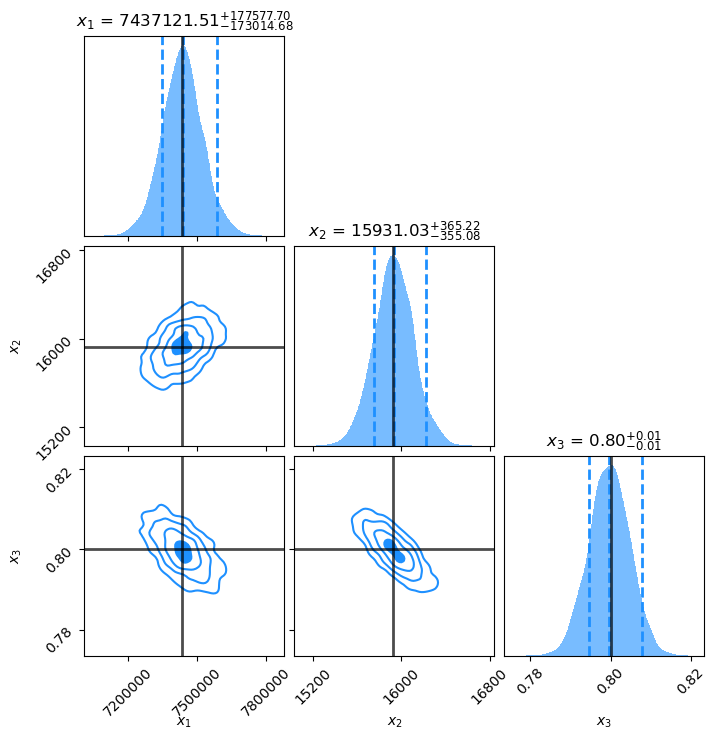

In [169]:
_ = dyplot.cornerplot(runsampler.results, color='dodgerblue', truths=truevals_s,
                           truth_color='black', show_titles=True,
                           quantiles=[0.15,0.5,0.95], max_n_ticks=3)

In [170]:
samples_s = runsampler.results.samples_equal()

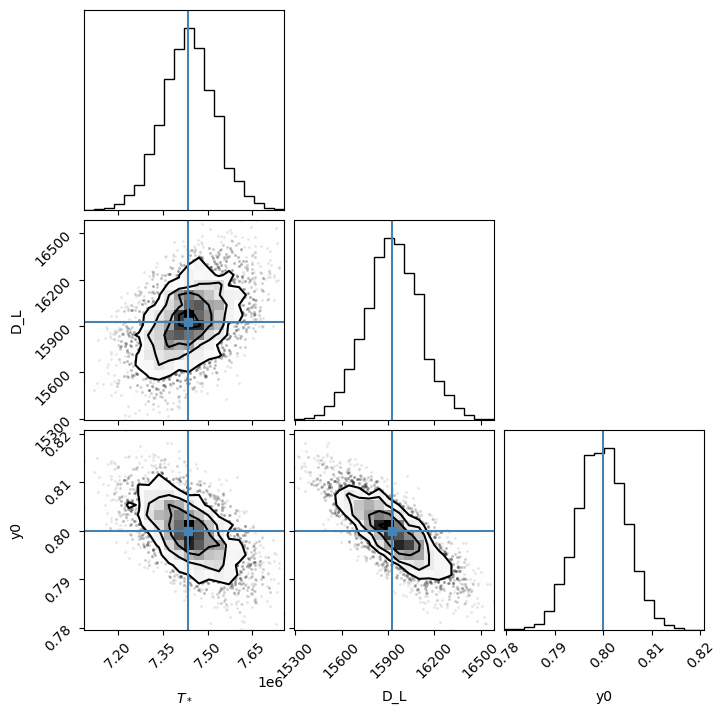

In [172]:
fig = corner.corner(samples_s, labels=labels_tot2_sis, truths=truevals_sis)

In [243]:
ysam = samples_s[:,2]

x10_sam_derived = ysam + 1
x20_sam_derived = ysam - 1


In [245]:
samples_s.shape

(10972, 3)

In [248]:
samples_im_derived = np.zeros((samples_s.shape[0],4))
samples_im_derived[:,0] = samples_s[:,0]
samples_im_derived[:,1] = samples_s[:,1]
samples_im_derived[:,2] = x10_sam_derived
samples_im_derived[:,3] = x20_sam_derived

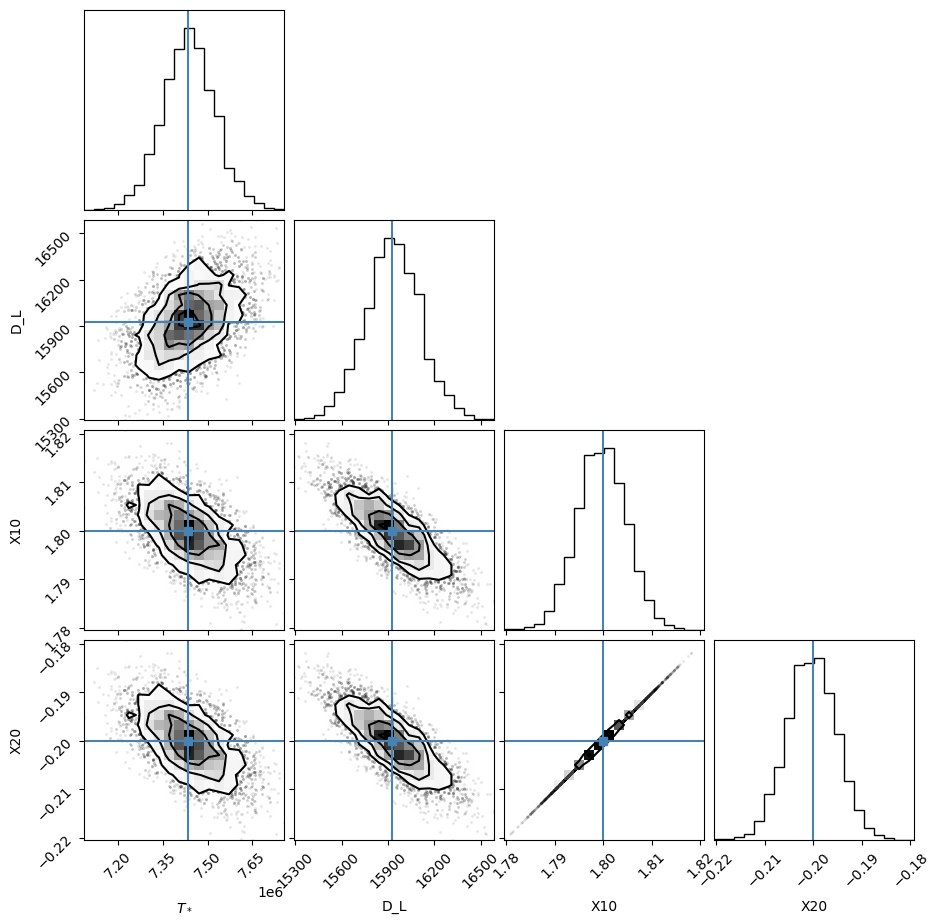

In [249]:
fig = corner.corner(samples_im_derived, labels=labels_tot2_im, truths=truevals_im)

In [219]:
%%time
runsampler_im = dynesty.NestedSampler(loglike_im,ptform_im,ndim=4,nlive=600)#,sample='hslice')

CPU times: user 369 ms, sys: 37.6 ms, total: 407 ms
Wall time: 497 ms


In [221]:
runsampler_im.run_nested(dlogz=0.005)

4148it [01:35,  1.21it/s, bound: 58 | nc: 1069 | ncall: 72422 | eff(%):  5.728 | loglstar:   -inf < -4037.992 <    inf | logz: -4051.986 +/-  0.153 | dlogz: 3841.509 >  0.005]/Users/souvik/miniconda3/envs/herculens-env/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4152it [01:41,  1.08s/it, bound: 62 | nc: 128 | ncall: 76130 | eff(%):  5.454 | loglstar:   -inf < -4029.833 <    inf | logz: -4043.217 +/-  0.147 | dlogz: 3828.064 >  0.005]/Users/souvik/miniconda3/envs/herculens-env/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal b

In [222]:
truevals_im = jnp.array([Tstar_true, dL_true, x0_true[0]/theta_E_true, x0_true[1]/theta_E_true])
labels_tot2_im = ['$T_*$','D_L','X10','X20']

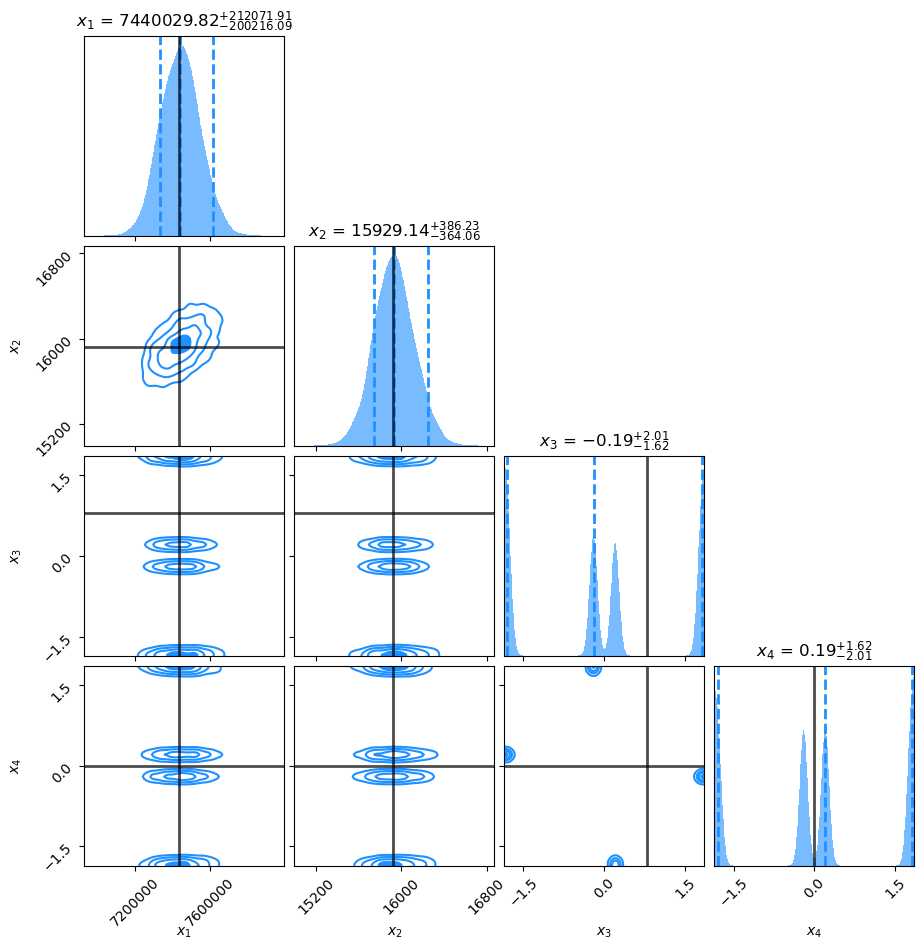

In [223]:
_ = dyplot.cornerplot(runsampler_im.results, color='dodgerblue', truths=truevals_s,
                           truth_color='black', show_titles=True,
                           quantiles=[0.15,0.5,0.95], max_n_ticks=3)

In [224]:
samples_im = runsampler_im.results.samples_equal()

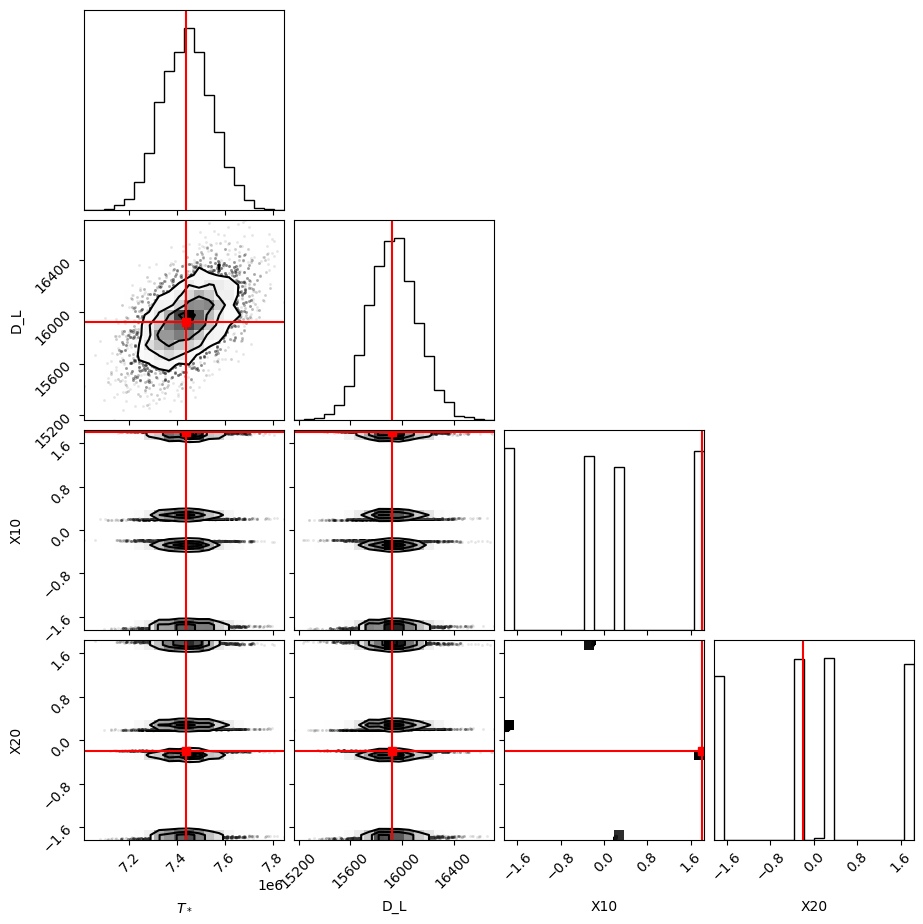

In [228]:
fig = corner.corner(samples_im, labels=labels_tot2_im, truths=truevals_im,truth_color='r')

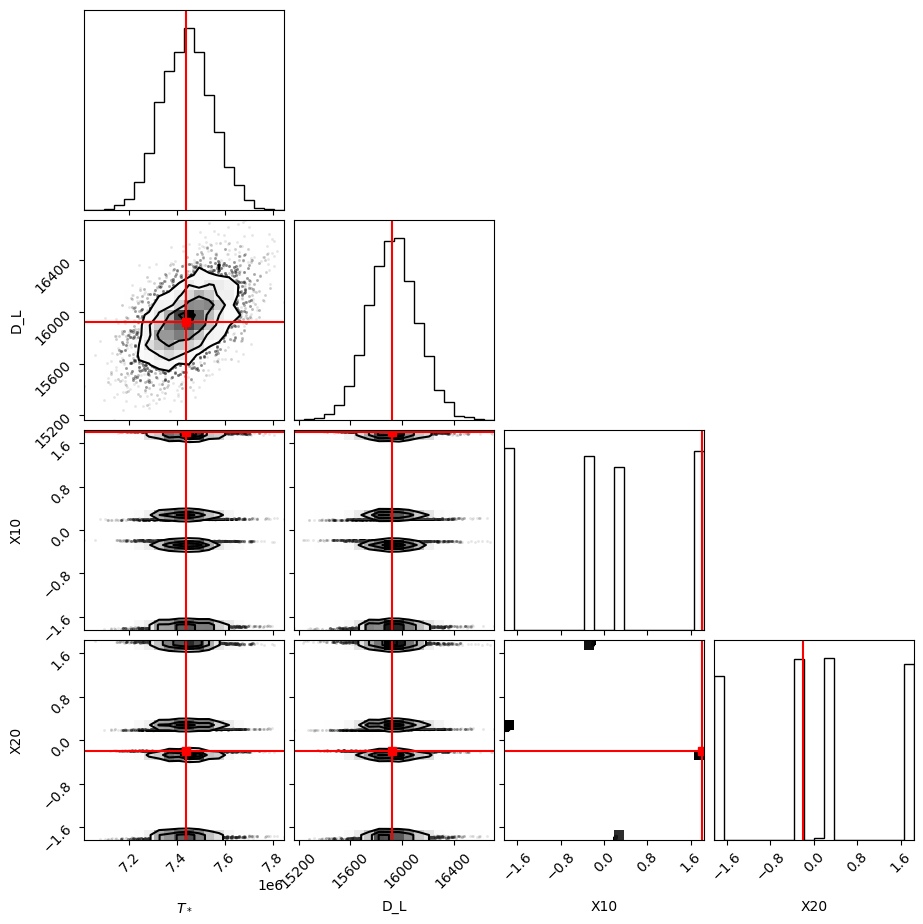

In [251]:
fig = corner.corner(samples_im, labels=labels_tot2_im, truths=truevals_im,truth_color='r')

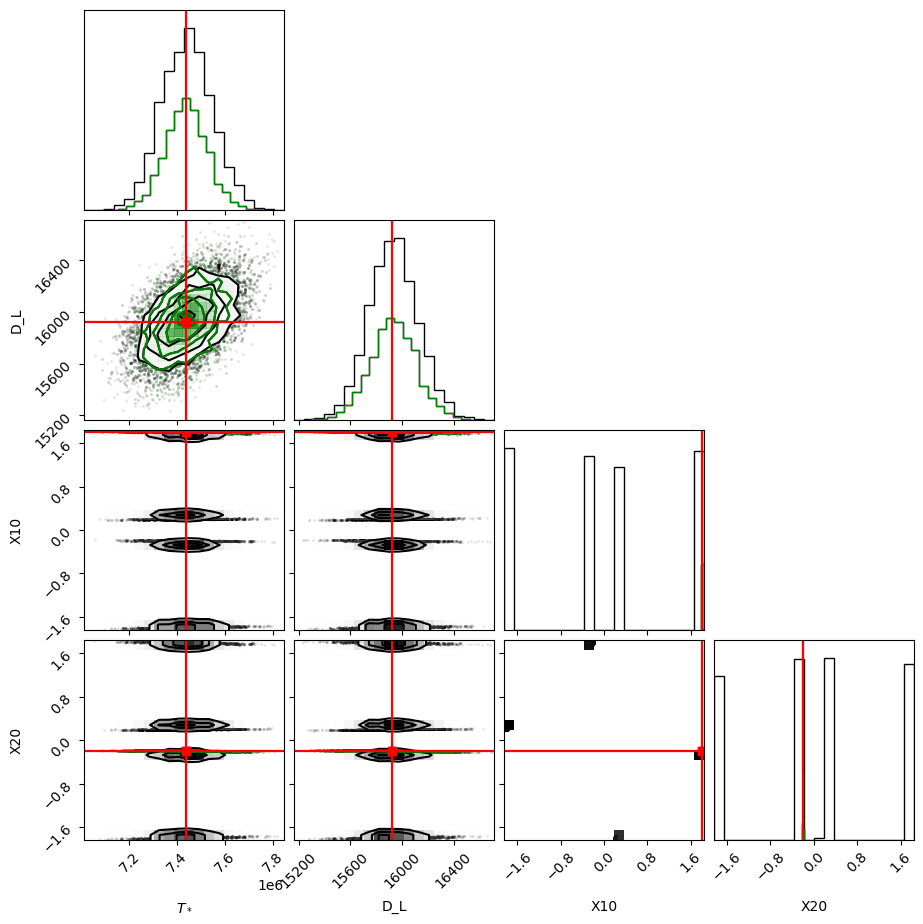

In [253]:
corner.corner(samples_im_derived, labels=labels_tot2_im, truths=truevals_im,color='g',truth_color='r',fig=fig)

In [229]:
x10_sam = samples_im[:,2]
x20_sam = samples_im[:,3]

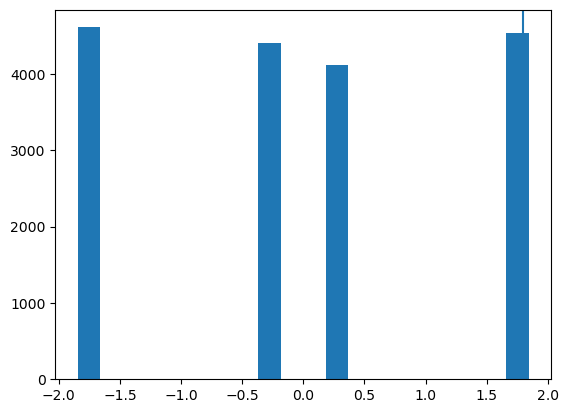

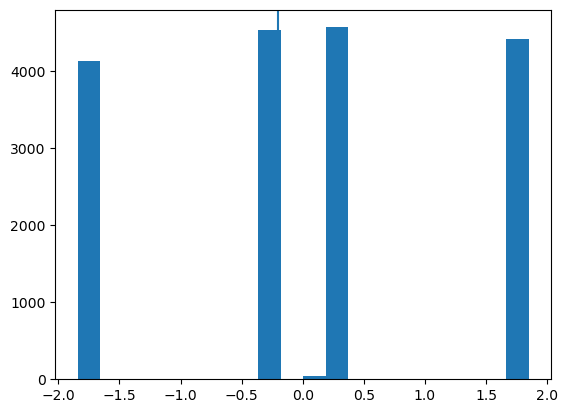

In [234]:
plt.hist(x10_sam,bins=20)
plt.axvline(x0_true[0])
plt.show()

plt.hist(x20_sam,bins=20)
plt.axvline(x0_true[1])
plt.show()


In [254]:
y1 = x10_sam - x10_sam/abs(x10_sam)
y2 = x20_sam - x20_sam/abs(x20_sam)

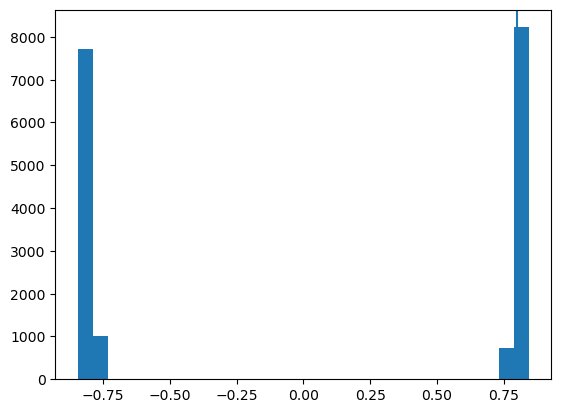

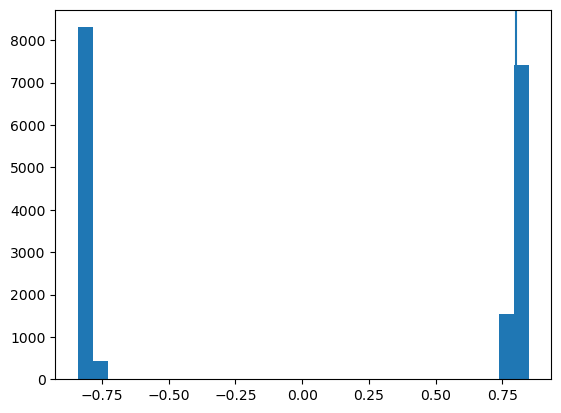

In [255]:
plt.hist(y1,bins=30)
plt.axvline(y0true)
plt.show()

plt.hist(y2,bins=30)
plt.axvline(y0true)
plt.show()

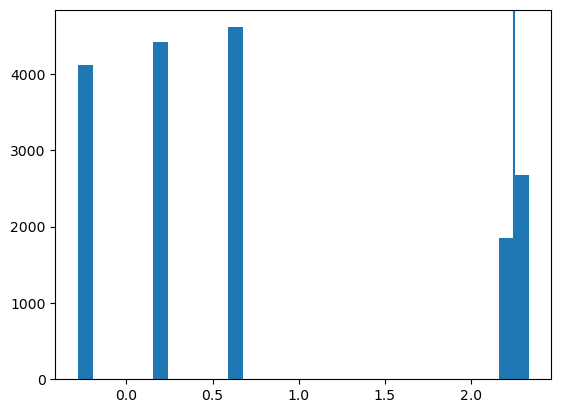

In [242]:
mu1 = x10_sam/(x10_sam-1)
plt.hist(mu1,bins=30)
plt.axvline(magnifications_true[0])